In [1]:
# Importing requird python packages
# Path to hsmpy package
HSMPY_PATH = r'C:\Users\MR068144\Downloads\Python Scripts'
import sys, os, arcpy, csv, json, math
sys.path.append(HSMPY_PATH)
import hsmpy3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from IPython.display import Image
from IPython.core.display import HTML 
import subprocess 
import webbrowser
import time
import copy
from __future__ import print_function
from mailmerge import MailMerge
import shutil
import openpyxl
from time import gmtime, strftime
from ipywidgets import FloatProgress
print(strftime("%Y-%m-%d %H:%M:%S"))

2018-08-17 13:40:42


In [2]:
# Parameter Definitions
# Analysis Years
Years = range(2005,2017)

# Project Folders and GDBs
Project_DIR = r'\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\4_WorkData\WO8\Rumble_Strips\3.Evaluation'
Project_GDB = Project_DIR + '\\2.RS_GDB.gdb'
Project_Output = Project_DIR + '\\3.Python_Notebook'

# Roadway and Crash Data
IRISPath = r'\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\7_BaseData\Master_BaseFiles_Data\5.0_Roadway_Layer\IRIS'
IRISPath = r'C:\Users\mr068144\Downloads\IRIS\IL_IRIS.gdb'
IRIS_Route = {y:os.path.join(IRISPath,'HWY'+str(y)+'_route') for y in Years}
IRIS_Table = {y:os.path.join(IRISPath,'HWY'+str(y)+'_table_HCurve') for y in Years}
CrashPath = r'C:\Users\mr068144\Downloads\IL Crash Data\IL_Crash.gdb'
CrashData = {y:CrashPath + '\\CrashExtract_' + str(y) + '_GIS' for y in Years}
Fields = ['AADT','O_SHD1_TYP','O_SHD1_WTH','O_SHD2_TYP','O_SHD2_WTH','LN_WTH','Radius','CurveLen']
RouteID = 'INVENTORY'
BMP = 'BEG_STA'
EMP = 'END_STA'

# Project Features
RS_Contracts = Project_GDB + '\\RS_Cont_Loc'
Selected_Sites = Project_GDB + '\\Selected_Sites_RS_Data'
Verified_Sites = Project_GDB + '\\Verified_Sites'


In [4]:
#Read Crash Data
print(strftime("%Y-%m-%d %H:%M:%S"))
SelFields = ['Crash_injury_severity','Nbr_of_Vehicles','Type_of_crash']
Crash_DF = pd.DataFrame()
for year in range(2005,2017):
    df = hsmpy3.common.FCtoDF(CrashData[year],readGeometry=False,selectedFields=SelFields)
    df['Year'] = year
    Crash_DF = pd.concat([Crash_DF,df])
    print(year)
print(Crash_DF.shape)
print(strftime("%Y-%m-%d %H:%M:%S"))

2018-08-15 16:19:00
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
(4020749, 4)
2018-08-15 16:59:53


In [5]:
def CrashType(ct,nv):
    ct = ct.lower()
    if nv==1:
        if ct == 'animal':
            return('Collision with Animal')
        if ct == 'pedalcyclist':
            return('Collision with Bicycle')
        if ct == 'pedestrian':
            return('Collision with Pedestrian')
        if ct == 'overturned':
            return('Overturned')
        #if ct in ['fixed object','sideswipe opposite direction','other object','head on','other non collision','other non-collision']:
        if ct in ['fixed object','sideswipe opposite direction','head on']:
            return('Ran off road')
        if ct in ['other non collision','other non-collision','other object']:
            return('Other')
            
    if nv>1:
        if ct == 'angle':
            return('Angle Collision')
        if ct == 'rear end':
            return('Rear end Collision')
        if ct == 'head on':
            return('Head on Collision')
        if ct in ['sideswipe opposite direction','sideswipe same direction']:
            return('Sideswipe Collision')
        return('Other MV Collision')
            
RdDepart = ['Overturned','Head on Collision','Sideswipe Collision','Ran off road'] 
Crash_DF['RD'] = [{True:1,False:0}[CrashType(ct,nv) in RdDepart] for ct,nv in zip(Crash_DF.Type_of_crash,Crash_DF.Nbr_of_Vehicles)] 

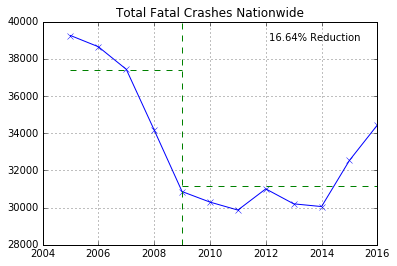

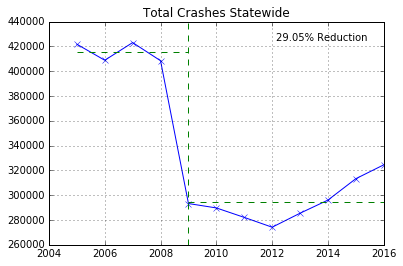

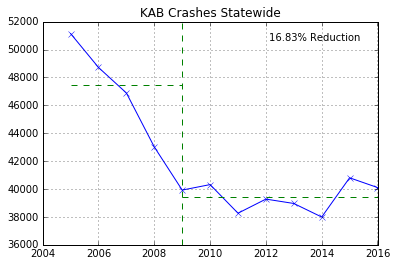

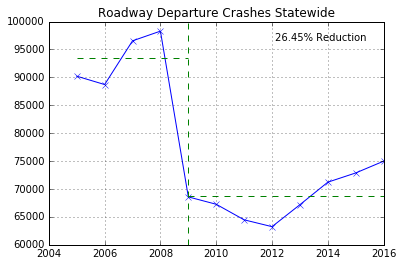

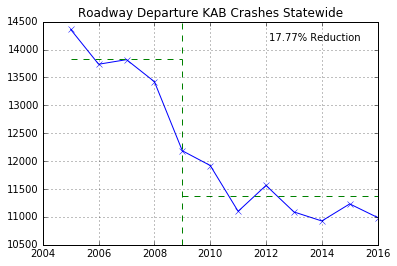

In [6]:
left, width = .1, .85
bottom, height = .1, .85
right = left + width
top = bottom + height    

y = [2016 ,2015 ,2014 ,2013 ,2012 ,2011 ,2010 ,2009 ,2008 ,2007 ,2006 ,2005 ,2004 ,2003 ,2002 ,2001 ,2000 ,1999 ,1998 ,1997 ,1996 ,1995 ,1994 ]
k = [34439,32539,30056,30202,31006,29867,30296,30862,34172,37435,38648,39252,38444,38477,38491,37862,37526,37140,37107,37324,37494,37241,36254]
FARS_DF = pd.DataFrame()
FARS_DF['KCrashes'] = k
FARS_DF.index = y
FARS_DF = FARS_DF.sort_index()
df = FARS_DF
Tot = FARS_DF.loc[list(range(2005,2017))]
plt.plot(Tot,'-x')
plt.axvline(x=2009,color='green',ls='--')
m1 = df.loc[[2005,2006,2007,2008]].mean().item()
m2 = df.loc[[2009,2010,2011,2012,2013,2014,2015,2016]].mean().item()
plt.axhline(y=m1,xmin=1.0/12,xmax=2.5/6,color='green',ls='--')
plt.axhline(y=m2,xmin=2.5/6,xmax=1,color='green',ls='--')
plt.gca().text(right, top, '{:.2%} Reduction'.format((m1-m2)/m1),horizontalalignment='right',verticalalignment='top',transform=plt.gca().transAxes)
plt.title('Total Fatal Crashes Nationwide')
plt.grid()
plt.savefig('Fars.png',transparent=False)
plt.show()

df = pd.DataFrame(Crash_DF['Year'].value_counts())
Tot = df.sort_index()
plt.plot(Tot,'-x')
plt.axvline(x=2009,color='green',ls='--')
m1 = df.loc[[2005,2006,2007,2008]].mean().item()
m2 = df.loc[[2009,2010,2011,2012,2013,2014,2015,2016]].mean().item()
plt.axhline(y=m1,xmin=1.0/12,xmax=2.5/6,color='green',ls='--')
plt.axhline(y=m2,xmin=2.5/6,xmax=1,color='green',ls='--')
plt.gca().text(right, top, '{:.2%} Reduction'.format((m1-m2)/m1),horizontalalignment='right',verticalalignment='top',transform=plt.gca().transAxes)
plt.grid()
plt.title('Total Crashes Statewide')
plt.savefig('Tot.png',transparent=False)
plt.show()

df = pd.DataFrame(Crash_DF[(Crash_DF.Crash_injury_severity.isin(['Fatal Crash','A Injury Crash','B Injury Crash']))]['Year'].value_counts())
KAB = df.sort_index()
plt.plot(KAB,'-x')
plt.axvline(x=2009,color='green',ls='--')
m1 = df.loc[[2005,2006,2007,2008]].mean().item()
m2 = df.loc[[2009,2010,2011,2012,2013,2014,2015,2016]].mean().item()
plt.axhline(y=m1,xmin=1.0/12,xmax=2.5/6,color='green',ls='--')
plt.axhline(y=m2,xmin=2.5/6,xmax=1,color='green',ls='--')
plt.gca().text(right, top, '{:.2%} Reduction'.format((m1-m2)/m1),horizontalalignment='right',verticalalignment='top',transform=plt.gca().transAxes)
plt.grid()
plt.title('KAB Crashes Statewide')
plt.savefig('KAB.png',transparent=False)
plt.show()

df = pd.DataFrame(Crash_DF[(Crash_DF.RD==1)]['Year'].value_counts())
RD = df.sort_index()
plt.plot(RD,'-x')
plt.axvline(x=2009,color='green',ls='--')
m1 = df.loc[[2005,2006,2007,2008]].mean().item()
m2 = df.loc[[2009,2010,2011,2012,2013,2014,2015,2016]].mean().item()
plt.axhline(y=m1,xmin=1.0/12,xmax=2.5/6,color='green',ls='--')
plt.axhline(y=m2,xmin=2.5/6,xmax=1,color='green',ls='--')
plt.grid()
plt.gca().text(right, top, '{:.2%} Reduction'.format((m1-m2)/m1),horizontalalignment='right',verticalalignment='top',transform=plt.gca().transAxes)
plt.title('Roadway Departure Crashes Statewide')
plt.savefig('RD.png',transparent=False)
plt.show()

df = pd.DataFrame(Crash_DF[(Crash_DF.RD==1) & (Crash_DF.Crash_injury_severity.isin(['Fatal Crash','A Injury Crash','B Injury Crash']))]['Year'].value_counts())
RDKAB = df.sort_index()
plt.plot(RDKAB,'-x')
plt.axvline(x=2009,color='green',ls='--')
m1 = df.loc[[2005,2006,2007,2008]].mean().item()
m2 = df.loc[[2009,2010,2011,2012,2013,2014,2015,2016]].mean().item()
plt.axhline(y=m1,xmin=1.0/12,xmax=2.5/6,color='green',ls='--')
plt.axhline(y=m2,xmin=2.5/6,xmax=1,color='green',ls='--')
plt.grid()
plt.gca().text(right, top, '{:.2%} Reduction'.format((m1-m2)/m1),horizontalalignment='right',verticalalignment='top',transform=plt.gca().transAxes)
plt.title('Roadway Departure KAB Crashes Statewide')
plt.savefig('RDKAB.png',transparent=False)
plt.show()

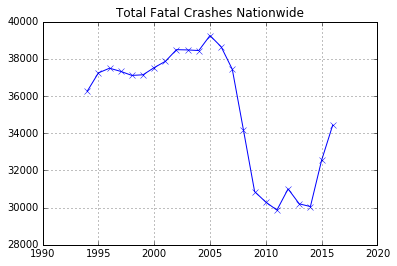

In [7]:
y = [2016 ,2015 ,2014 ,2013 ,2012 ,2011 ,2010 ,2009 ,2008 ,2007 ,2006 ,2005 ,2004 ,2003 ,2002 ,2001 ,2000 ,1999 ,1998 ,1997 ,1996 ,1995 ,1994 ]
k = [34439,32539,30056,30202,31006,29867,30296,30862,34172,37435,38648,39252,38444,38477,38491,37862,37526,37140,37107,37324,37494,37241,36254]
FARS_DF = pd.DataFrame()
FARS_DF['KCrashes'] = k
FARS_DF.index = y
FARS_DF = FARS_DF.sort_index()
df = FARS_DF
Tot = FARS_DF
plt.plot(Tot,'-x')
plt.grid()
plt.title('Total Fatal Crashes Nationwide')
plt.savefig('Fars_All.png',transparent=False)
plt.show()


In [4]:
hsmpy3.common.ListFCinGDBorMDB(Project_GDB)

['RS_Cont_Loc',
 'Selected_Sites_RS_Data',
 'Verified_Sites',
 'Sites_2005',
 'Sites_2006',
 'Sites_2007',
 'Sites_2008',
 'Sites_2009',
 'Sites_2010',
 'Sites_2011',
 'Sites_2012',
 'Sites_2013',
 'Sites_2014',
 'Sites_2015',
 'Sites_2016',
 'AllCrashes_Before',
 'AllCrashes_After',
 'Crash_2005',
 'Crash_2006',
 'Crash_2007',
 'Crash_2008',
 'Crash_2009',
 'Crash_2010',
 'Crash_2011',
 'Crash_2012',
 'Crash_2013',
 'Crash_2014',
 'Crash_2015',
 'Crash_2016',
 'SitesSummary_All',
 'Sites_Summary']

In [9]:
Cont_Path = r'\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\4_WorkData\WO19\HSIP_Tracking_Tool\5.Documents'
Cont_DF = pd.read_excel(Cont_Path + '\\Cont_DF.xlsx')
df = hsmpy3.common.FCtoDF(Project_GDB + '\\Sites_Summary')
cL = []
for c in df.CONT_NUM:
    if len(c)==5:
        cL.append(c)
    if len(c)==10:
        cL.append(c[:5])
        cL.append(c[5:10])
    if len(c)==15:
        cL.append(c[:5])
        cL.append(c[5:10])
        cL.append(c[10:])
cL = list(set(cL))
len(cL)
RS_DF = pd.DataFrame()
RS_DF['ContNum'] = cL
RS_DF['IsInHSIP'] = [(c in Cont_DF.ContNum) for c in RS_DF.ContNum]
RS_DF.IsInHSIP.value_counts()

False    25
True     18
Name: IsInHSIP, dtype: int64

In [16]:
d = Project_DIR + '\\10.SelectedContracts'
payL = hsmpy3.il.DownloadPayItems()
RS_Cont_DF = pd.DataFrame()
for c in RS_DF.ContNum:
    L = hsmpy3.il.ScrapeContract(cont=c,PayItem_DFList=payL)
    df = L[1]
    df['ContNum'] = c
    df['Contractor'] = L[0]
    df = df.sort_values('COMPLETED_AMT',ascending=False)
    df.to_excel(d+'\\'+c+'.xlsx')
    RS_Cont_DF = pd.concat([RS_Cont_DF,df])
    print(c)

WARNING *** file size (5202793) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (485712) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
60D37
66B91
68890
76B23
76F99
72D95
76D38
72E18
68960
78224
60V12
76530
74428
64E17
72C97
78352
64H62
60I29
74552
72765
68961
72B30
76F17
66913
64H68
78417
60N28
72B13
68770
64F06
76E10
72D84
72835
74504
76G00
60I37
68915
78038
68969
66770
60K67
72E47
72B32


In [49]:
#S_DF = pd.read_excel(r'\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\4_WorkData\WO8\Rumble_Strips\2.Data_Collection\RumbleStrip_Data_12302015.xlsx')
len(set(S_DF.Job))

744

In [15]:
cL.sort()
p = r'\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\4_WorkData\WO8\Rumble_Strips\2.Data_Collection\RumbleStrip_Data_PDFs_12302015'
d = Project_DIR + '\\10.SelectedContracts'
fL = []
for f in os.listdir(p):
    if os.path.isfile(os.path.join(p, f)) and f.split('.')[1]=='pdf':
        for c in cL:
            #print(c,f,f.find(c))
            if f.find(c)!=-1:
                fL.append(os.path.join(p, f))
                print(c,f)
                shutil.copyfile(os.path.join(p, f),os.path.join(d,f))

60D37 60D37_20080307.pdf
60I29 60I29_20110429.pdf
60I37 60I37_20100514.pdf
60K67 60K67_20110121.pdf
60N28 60N28_20130118.pdf
60V12 60V12_20140801.pdf
64E17 64E17_20100730.pdf
64F06 64F06_20090403.pdf
64H62 64H62_20140228.pdf
64H68 64H68_20120309.pdf
66770 66770_20080613.pdf
66913 66913_20101105.pdf
66B91 66B91_20141121.pdf
68770 68770_20080425.pdf
68890 68890_20090515.pdf
68915 68915_20100305.pdf
68960 68960_20100423.pdf
68961 68961_20100611.pdf
68969 68969_20100730.pdf
72765 72765_20100115.pdf
72835 72835_20090403.pdf
72B13 72B13_20100514.pdf
72B30 72B30_20080118.pdf
72B32 72B32_20080425.pdf
72C97 72C97_20100115.pdf
72D84 72D84_20111118.pdf
72D95 72D95_20110311.pdf
72E18 72E18_20111118.pdf
72E47 72E47_20120120.pdf
74428 74428_20100305.pdf
74504 74504_20110429.pdf
74552 74552_20130308.pdf
76530 76530_20080613.pdf
76B23 76B23_20080118.pdf
76D38 76D38_20100423.pdf
76E10 76E10_20110617.pdf
76F17 76F17_20120427.pdf
76F99 76F99_20130308.pdf
76G00 76G00_20130426.pdf
78038 78038_20080613.pdf


In [19]:
for c in cL:
    print(RS_Cont_DF[RS_Cont_DF.ContNum==c]['COMPLETED_AMT'].sum())

1268644.7499999998
3055955.399999999
5789714.549999999
242740.75999999995
607476.5299999999
1078528.5100000005
233727.52000000002
661373.2800000001
4060468.869999999
36997.26
1886777.37
2649521.25
684648.4000000001
28251496.05
379499.27
73180.56999999999
2168885.74
2221323.46
3252556.7300000004
3762350.110000001
3143167.639999999
111895.13
249822.72000000003
528313.8899999999
41444.25
1047324.4199999996
1492478.8500000003
4176737.2899999986
552692.6799999999
1628081.2699999998
1180775.4799999997
495055.66000000003
5268038.329999999
1604168.8200000003
615900.57
1611511.0200000003
5251239.650000001
1815437.1799999997
596423.8400000001
1625800.47
1468002.99
976120.03
242026.89999999994
